### [아이디어 주제]

#### 1. 에너지 자립 전략
 - 가정용 태양광 + ESS 장마철 분석


목적: 가정용은 자가소비 중심으로 에너지 자립자족 전략 세움

분석 과정
 - 연속 강우일시 발전 감소량 추정
 - 연속일수가 긴 순서대로 정렬해서 TOP 5
 - 가정용 태양광 -> ESS 충당 -> 한전 순으로 시뮬레이션
 - TOP5에 대해서 히트맵(seaborn 활용) 그리기

데이터
 - 장마철(6~7월), 비장마철(4~5월)
 - 장마철 강수량: 2020~2025년 6~7월 일별 데이터
 - 비장마철 강수량: 2020~2025년 4~5월 일별 데이터

한편 자가용 태양광 생산량 비율이 압도적으로 큰 지역은 서울이다. 
서울의 태양광 발전 전체 생산량은 0.23TWh로 전국 생산량의 1.2%에 불과한 매우 적은 양이다. 
하지만 자가용 태양광 생산량은 서울시 전체 생산량의 81%로 타 지역과 매우 대조적이다. 

서울의 경우 정책적인 지원이 큰 역할을 한 것으로 풀이된다. 
실제로 서울시는 2012년부터 100kW 이하 소형 태양광발전설비 보급 확대를 위해 발전차액보조금지원, 
태양광 발전 설비 저리 융자지원 등의 제도를 운영하였다. 
2015년부터 소형 태양광 발전시설 보조금 확대 등 정책적인 지원을 꾸준히 해오고 있다. 

출처 : 한국에너지기술연구원 기술정책플랫폼 https://www.kier.re.kr/tpp/tppBoard/view/26?menuId=MENU00962

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [8]:
# [데이터 읽기]

import pandas as pd
import glob

def read_csv(filename):         # 기상청 CSV 파일 읽기
    # '날짜'가 나오는 줄 찾기
    with open(filename, 'r', encoding='cp949') as f:
        for i, line in enumerate(f):  # enumerate(f): 파일을 한 줄씩 읽으면서 줄 번호(i) 같이 가져옴
            if '날짜' in line:
                skiprows = i    # 이 줄까지 건너뛰기
                break

    # CSV 읽기
    df = pd.read_csv(filename, encoding='cp949', skiprows=skiprows)

    # 날짜를 datetime 형식으로 변환
    df['날짜'] = pd.to_datetime(df['날짜'])

    # 강수량을 숫자로 변환 (빈 값은 0으로)
    df['강수량(mm)'] = pd.to_numeric(df['강수량(mm)'], errors='coerce').fillna(0) # errors='coerce': 숫자로 못 바꾸면 NaN
    return df[['날짜', '강수량(mm)']]

files = sorted(glob.glob('../data/daily/seoul_rain_*.csv')) # 장마철 파일 읽기
all_data = [read_csv(f) for f in files]  # 모든 파일을 읽어서 리스트에 저장
df = pd.concat(all_data).sort_values('날짜') # 리스트의 DataFrame들을 하나로 합치기
df['비'] = df['강수량(mm)'] >= 1.0  # 비 오는 날 표시 (1mm 이상 = 비)
print(f"\n[데이터]\n장마철 (6~7월) {len(files)}개년")
print(f"총 {len(df)}일 / 비: {df['비'].sum()}일")


# [연속 강우일 찾기]

"""
알고리즘:
비가 오면 카운트 증가
비가 안 오면 카운트 리셋
2일 이상 연속이면 기록, 카운트 리셋
"""

consecutive = []  # 결과 저장할 리스트
current = 0       # 현재 연속 일수
start = None      # 연속 시작 날짜

for i, row in df.iterrows():    # 모든 날짜를 하나씩 확인

    if row['비']:               # 비가 오면
        if current == 0:        # 연속 비가 처음 시작되는 날이면 시작 날짜 기록
            start = row['날짜']
        current += 1
    
    else:                       # 비가 안 오면
        if current >= 2:        # 2일 이상이었으면 저장
            consecutive.append({
                'start': start,
                'days': current
            })
        current = 0             # 리셋

# 연속일수가 긴 순서대로 정렬해서 TOP 5
top5 = sorted(consecutive, key=lambda x: x['days'], reverse=True)[:5]

print(f"\n[연속 강우] 2일 이상: {len(consecutive)}번")
print(f"\n[TOP 5]")
for i, p in enumerate(top5, 1):
    print(f" {i}위: {p['days']}일 ({p['start'].date()})")



[데이터]
장마철 (6~7월) 6개년
총 366일 / 비: 126일

[연속 강우] 2일 이상: 33번

[TOP 5]
 1위: 8일 (2024-07-20)
 2위: 7일 (2025-07-14)
 3위: 6일 (2023-07-13)
 4위: 5일 (2022-07-20)
 5위: 5일 (2024-07-04)


In [9]:
"""
가정용 태양광 + ESS 시스템 구성
- 태양광: 5kW (일반 주택 표준)
- 맑은 날 발전: 30kWh/일 (5kW x 8시간 x 0.75효율)
- 하루소비: 13kWh/일 (4인 가족 평균)
- ESS: 30kWh (약 2일분)

ESS 역할
-  낮-밤 전력 이동 (일일 주기)
-  장마철 단기 발전 부족(1~2일 규모)에 대한 완충 및 한전 의존도 감소시키는 역할
-  연속 강우 시 태양광 출력 저하 구간에서 소비 전력을 부분적으로 보완
"""

# ============================
# 시뮬레이션 결과
# ============================


맑은날_발전 = 30        # kWh/일
하루_소비 = 13          # kWh/일
ESS_용량 = 30           # kWh

# TOP 5 각각에 대해 시뮬레이션
히트맵_데이터 = []       # 히트맵용 데이터

for rank, p in enumerate(top5, 1):

    # [1) 해당 기간의 평균 강수량]

    # 시작일부터 연속일수만큼의 기간 선택
    mask = (df['날짜'] >= p['start']) & \
           (df['날짜'] <= p['start'] + pd.Timedelta(days=p['days']))     # pd.Timdedelta(day=5) 의미: 5일을 의마하는 시간 객체
                                                                         # 2024-07-15 + 5일 = 2024-07-20
    
    avg_rain = df.loc[mask, '강수량(mm)'].mean()
    total_rain = df.loc[mask, '강수량(mm)'].sum()

    # [2) 강수량 -> 발전량 추정]

    """
    비가 많으면 일조시간 감소 -> 발전량 감소
    - 평균 10mm 미만: 맑은 날의 50% (15kWh)
    - 평균 10mm 이상: 맑은 날의 20% (6kWh)

    참고 논문:
- Dawood et al. (2023). Solar Energy and Factors 
  Affecting the Efficiency in Erbil/Kurdistan
- 습도 증가 시 30% 효율 손실
- 비/흐린날 실측: 맑은날 대비 14~20%
    """

    if avg_rain < 10:
        일일발전 = 맑은날_발전 * 0.5
    else:
        일일발전 = 맑은날_발전 * 0.2
    
    # 일일 부족량 = 소비 - 발전
    일일부족 = max(0, 하루_소비 - 일일발전)

    # [3) ESS 시뮬레이션]

    """
    초기: ESS 만충 (30kWh)

    매일:
    1. 태양광 발전으로 하루 소비 충당
    2. 부족하면 ESS에서 사용
    3. ESS도 부족하면 한전 사용
    """

    ESS_잔량 = ESS_용량    # 초기 만충
    총_한전 = 0            # 한전 사용량 = 0

    # 연속일수만큼 반복
    for day in range(p['days']):  
        부족 = 일일부족     # 하루 부족분 = 소비 - 발전

        # ESS에서 먼저 사용
        ESS_사용 = min(부족, ESS_잔량)       # 예시 (30kWh ESS)  # 부족 < ESS_잔량 -> 부족분 전부 ESS에서
                                                                # 부족 > ESS_잔량 -> ESS 다 쓰고 나머지 한전
        ESS_잔량 -= ESS_사용                 # ESS_사용 = min(7, 30) = 7kWh
        부족 -= ESS_사용                     # ESS_잔량 = 30 - 7 = 23kWh
                                             # 부족 = 7 - 7 = 0kWh
        # 남은 부족분은 한전
        총_한전 += 부족

    # [4) 자급률 계산]

    """
    자급률 = (태양광 + ESS 사용) / 총 필요량 x 100
    """

    총_필요 = 하루_소비 * p['days']
    총_발전 = 일일발전 * p['days']
    ESS_사용량 = ESS_용량 - ESS_잔량
    자급률 = ((총_발전 + ESS_사용량) / 총_필요) * 100

    # [5) 히트맵용 데이터 저장]   # 결과를 딕셔너리로 저장 {'이름': '값'} 형태

    히트맵_데이터.append({
        '순위': f'{rank}위',
        '연속일수': p['days'],
        '총강수량': total_rain,
        '평균강수': avg_rain,
        '일일발전': 일일발전,
        '한전사용': 총_한전,
        '자급률': 자급률
    })

히트맵_df = pd.DataFrame(히트맵_데이터)   # DataFrame으로 변환

print(f"\n[시뮬레이션 결과]")
print(히트맵_df.to_string(index=False))

# CSV로도 저장
히트맵_df.to_csv('에너지_자립_전략_시뮬레이션_결과.csv', 
                 index=False, 
                 encoding='utf-8-sig')


[시뮬레이션 결과]
순위  연속일수  총강수량      평균강수  일일발전  한전사용        자급률
1위     8 184.3 20.477778   6.0  26.0  75.000000
2위     7 281.1 35.137500   6.0  19.0  79.120879
3위     6 180.0 25.714286   6.0  12.0  84.615385
4위     5  27.8  4.633333  15.0   0.0 115.384615
5위     5  60.6 10.100000   6.0   5.0  92.307692


In [4]:
# ============================
# 히트맵 정규화 부연설명
# ============================

"""
def normalize_01(series):

# [정의]: 서로 다른 범위의 값들을 같은 범위(0~1)로 맞춰주는 것

min_val = series.min()   # 가장 작은 값
max_val = series.max()   # 가장 큰 값

# 특수 케이스 처리
# if) 모든 값이 같으면? (예: [5, 5, 5, 5])
# -> 나누기가 0/0이 되어 오류!
# -> 그냥 중간값 0.5로 설정

if max_val == min_val:
    return pd.Series([0.5] * len(series), index=series.index)

# 정규화 계산
# [공식]: 정규화 = (값-최소값)/(최대값-최소)
# pandas는 자동으로 모든 값에 적용

normalized = (series - min_val) / (max_val - min_val)
return normalized
"""

'\ndef normalize_01(series):\n\n# [정의]: 서로 다른 범위의 값들을 같은 범위(0~1)로 맞춰주는 것\n\nmin_val = series.min()   # 가장 작은 값\nmax_val = series.max()   # 가장 큰 값\n\n# 특수 케이스 처리\n# if) 모든 값이 같으면? (예: [5, 5, 5, 5])\n# -> 나누기가 0/0이 되어 오류!\n# -> 그냥 중간값 0.5로 설정\n\nif max_val == min_val:\n    return pd.Series([0.5] * len(series), index=series.index)\n\n# 정규화 계산\n# [공식]: 정규화 = (값-최소값)/(최대값-최소)\n# pandas는 자동으로 모든 값에 적용\n\nnormalized = (series - min_val) / (max_val - min_val)\nreturn normalized\n'

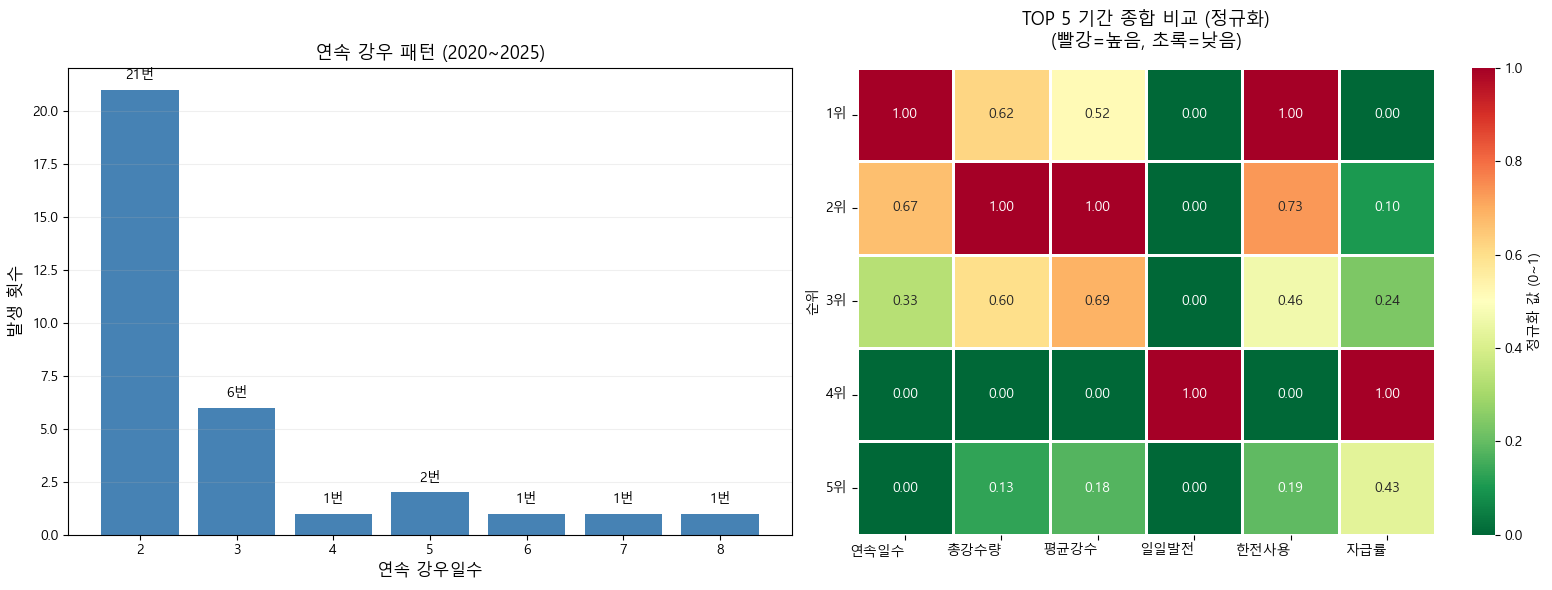

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))   # 그래프 2개

# ========================
# 그래프 1: 연속 강우 패턴
# ========================

# [1) 연속일 분포]

"""
며칠 연속이 몇 번 발생했는지 막대그래프
"""

days_list = [p['days'] for p in consecutive]  # 모든 연속 강우의 일수만 추출

days_counts = pd.Series(days_list).value_counts().sort_index()  # 각 값이 몇 번 나왔는지 세기

# 막대 그래프

ax1.bar(days_counts.index, days_counts.values, color='steelblue')
for x, y in zip(days_counts.index, days_counts.values):         # 막대 위에 숫자 표시
    ax1.text(x, y + 0.5, f'{y}번', ha='center', fontsize=10)

ax1.set_xlabel('연속 강우일수', fontsize=12)
ax1.set_ylabel('발생 횟수', fontsize=12)
ax1.set_title('연속 강우 패턴 (2020~2025)', fontsize=13)

ax1.grid(axis='y', alpha=0.2)

# ============================
# 그래프 2: TOP 5 메트릭 히트맵
# ============================

"""
TOP 5 기간의 여러 지표를 한눈에 비교

[우리가 그릴 것]
행(Y축): 1위, 2위, 3위, 4위, 5위
열(X축): 연속일수, 총강수량, 평균강수, 일일발전, 한전사용, 자급률
색상: 빨강 = 높음, 파랑 = 낮음

예시:

- 연속일수 높음 = 나쁨(빨강)
- 발전량 높음 = 좋음(초록)
- 한전사용 높음 = 나쁨 (빨강)
"""

def normalize_01(series):
    """각 열을 0~1로 변환"""
    
    # [1단계] 최소, 최대 찾기
    min_val = series.min()
    max_val = series.max()
    
    # [2단계] 같은 값이면 중간값
    if max_val == min_val:
        return pd.Series([0.5] * len(series), index=series.index)
    
    # [3단계] 정규화
    # (값 - 최소) / (최대 - 최소)
    return (series - min_val) / (max_val - min_val)

# [1) 히트용 데이터 준비]

"""
DataFrame에서 '순위' 열을 인덱스(행 이름)로 변경

변경 전:
  순위  연속일수  총강수량
0  1위     3      184
1  2위     7      281

변경 후:
     연속일수  총강수량
1위     3      184
2위     7      281
"""
heatmap_data = 히트맵_df.set_index('순위')
heatmap_norm = heatmap_data.apply(normalize_01)


# [2) Seaborn 히트맵]

sns.heatmap(heatmap_norm, 
           annot=True,           # annot=annotation(주석), annot=True(각 칸에 숫자 표시), annot=False(색깔만)
           fmt='.2f',            # 정수
           cmap='RdYlGn_r',      # RdYlGn=Red-Yellow_green, -r=reverse(역순), 높은값=빨강, 낮은값=초록
           linewidths=1,         # 셀 사이 선 두께
           linecolor='white',    # 경계선 색
           cbar_kws={'label': '정규화 값 (0~1)'},  # cbar=color bar (색상 막대)
           ax=ax2)               # ax2 = 2번째 그래프 공간에 그리기

# [3) 그래프 생성]

# 제목
ax2.set_title('TOP 5 기간 종합 비교 (정규화)\n(빨강=높음, 초록=낮음)', 
             fontsize=13, pad=15)

# Y축 라벨
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)

# X축 라벨 회전
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, ha='right') # ha(가로정렬) = 'right'(오른쪽 정렬)

plt.tight_layout()      # 자동으로 여백 조정

plt.savefig(
    "6_연속_강우_패턴_히트맵.png",
    dpi=300,
    bbox_inches='tight'
)
plt.show()    

In [6]:
# ============================
# 분석 결과 요약
# ============================

print("="*30)
print("분석 결과 요약")
print("="*30)

max_days = top5[0]['days']
worst = 히트맵_df.iloc[0]

print(f"""
최악 시나리오 (6년간 데이터 기준)

   - 연속 강우: {max_days}일 (최장 기록)
   - 총 강수량: {worst['총강수량']:.1f}mm
   
   - 일일 발전: {worst['일일발전']:.0f}kWh 
   - 한전 의존: {worst['한전사용']:.1f}kWh ({max_days}일간 총 {worst['한전사용']:.0f}kWh)
   - 자급률: {worst['자급률']:.1f}%
   
   - ESS 없이는 {100-worst['자급률']:.0f}% 한전 의존!
""")

max_days = top5[0]['days']
worst = 히트맵_df.iloc[0]


분석 결과 요약

최악 시나리오 (6년간 데이터 기준)

   - 연속 강우: 8일 (최장 기록)
   - 총 강수량: 184.3mm

   - 일일 발전: 6kWh 
   - 한전 의존: 26.0kWh (8일간 총 26kWh)
   - 자급률: 75.0%

   - ESS 없이는 25% 한전 의존!



#### 2. 지도(folium) 활용 방안

서울 열린데이터광장: 서울시 공공태양광 시설 현황 데이터
서울시 에너지 지도 https://energyinfo.seoul.go.kr/portalMap/

기준일(2025-12-19)
서울 태양광 생산량 : 1,289,732kWh

[지역구별 태양광 발전량]

1. 태양광 생산량 상위, 하위 3개 역

상위 3개 지역
- 강서구 133,416kWh
- 송파구 114,119kWh
- 동대문구 81,524kWh

하위 3개 지역
- 동작구 23,947kWh
- 성북구 19,612kWh
- 용산구 16,411kWh


2. 자치구별 편차

- 왜 일부 자치구는 높은 설비용량, 발전량
- 지역의 지리적 조건 조사

3. (보류) ESS 설치 우선순위 지도:
장마철 발전 손실률 높은곳, 전력 소비량 높은곳, 태양광 설치량 낮은곳